In [79]:
import numpy as np
import pandas as pd

import gym
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.example import forest
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from gym import wrappers

import matplotlib.pyplot as plt
import seaborn

import time
import sys

# suppress warning
import warnings
warnings.filterwarnings('ignore')

# seed
np.random.seed(33)

<h3> Helper Functions</h3>

In [104]:
colors = {
    0: 'k',
    1: 'g'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management',f_size=5):
    rows = 25
    cols = 25
    
    # reshape policy array to be 2-D - assumes 500 states...
    policy = np.array(list(policy)).reshape(f_size,f_size)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, xlim=(-.01, f_size+0.01), ylim = (-.01, f_size+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(f_size):
        for j in range(f_size):
            y = f_size - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')
    
    plt.axis('off')
#     plt.savefig('./forest/' + title + '.png', dpi=400)
    

# code based on:
# https://github.com/dxganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        if type(observation) is tuple:
            observation = observation[0]
        steps=0
        while True:
#             print(observation)
# #             print(observation[0])
#             print(policy)
            action = policy[observation]
            observation, reward, terminated, truncated , info = env.step(action)
            steps+=1
            if terminated and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif terminated and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail

def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 1000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
#         if ep>=1000:
#             print('over limit')
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 


# code based on:
# https://github.com/dxganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

def vi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = []
    for g in xList:
        y.append(data_df.loc[data_df[xAttr] == g]['average_steps'].mean())
    sigma = []
    for g in xList:
        sigma.append(data_df.loc[data_df[xAttr] == g]['average_steps'].std())
    max = []
    for g in xList:
        max.append(data_df.loc[data_df[xAttr] == g]['average_steps'].max())


    #time
    time = []
    for g in xList:
        time.append(data_df.loc[data_df[xAttr] == g]['time'].mean())
    t_sigma = []
    for g in xList:
        t_sigma.append(data_df.loc[data_df[xAttr] == g]['time'].std())
    t_max = []
    for g in xList:
        t_max.append(data_df.loc[data_df[xAttr] == g]['time'].max())


    #reward
    reward = []
    for g in xList:
        reward.append(data_df.loc[data_df[xAttr] == g]['reward'].mean())
    r_sigma = []
    for g in xList:
        r_sigma.append(data_df.loc[data_df[xAttr] == g]['reward'].std())
    r_max = []
    for g in xList:
        r_max.append(data_df.loc[data_df[xAttr] == g]['reward'].max())


    #success
    success = []
    for g in xList:
        success.append(data_df.loc[data_df[xAttr] == g]['success_pct'].mean())
    s_sigma = []
    for g in xList:
        s_sigma.append(data_df.loc[data_df[xAttr] == g]['success_pct'].std())
    s_max = []
    for g in xList:
        s_max.append(data_df.loc[data_df[xAttr] == g]['success_pct'].max())

        
    #iteration
    iterations = []
    for g in xList:
        iterations.append(data_df.loc[data_df[xAttr] == g]['iterations'].mean())
    i_sigma = []
    for g in xList:
        i_sigma.append(data_df.loc[data_df[xAttr] == g]['iterations'].std())
    i_max = []
    for g in xList:
        i_max.append(data_df.loc[data_df[xAttr] == g]['iterations'].max())
        

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Average Steps')
    plt.plot(x, max, 'o--', label='Max Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Average/Max Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Average Reward')
    plt.plot(x, r_max, 'o--', label='Max Reward')
    plt.fill_between(x, np.array(reward)-np.array(r_sigma), np.array(reward)+np.array(r_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Average time')
    plt.plot(x, t_max, 'o--', label='Max time')
    plt.fill_between(x, np.array(time)-np.array(t_sigma), np.array(time)+np.array(t_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Average Success PCT')
    plt.plot(x, s_max, 'o--', label='Max Success PCT')
    plt.fill_between(x, np.array(success)-np.array(s_sigma), np.array(success)+np.array(s_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Average Iterations')
    plt.plot(x, i_max, 'o--', label='Max Iterations')
    plt.fill_between(x, np.array(iterations)-np.array(i_sigma), np.array(iterations)+np.array(i_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Iterations')
    plt.grid(True)
    plt.show()


def pi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = data_df['average_steps']
    sigma = data_df['steps_stddev']

    #time
    time = data_df['time']
    
    #reward
    reward = data_df['reward']

    #success
    success = data_df['success_pct']
    
    #iterations
    iterations = data_df['iterations']



    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Reward')
    plt.title('Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Time')
    plt.title('Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Success PCT')
    plt.title('Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Iterations')
    plt.title('iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('iterations')
    plt.grid(True)
    plt.show()

def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.grid(True)
    plt.show()
    
def plot_fm_policy(policy, title= 'Forest Management Converged Policy'):
    fig, ax = plt.subplots(figsize=(8, 3))
#     plt.xtics(range(len(fl8_q.policy)))
    for i in range(len(policy)):
        if policy[i] == 0:
            ax.vlines(i, 0, 1, linestyles='dashed', colors='red')
        if policy[i] == 1:
            ax.vlines(i, 0, 1, colors='blue')
    plt.title(title)
    plt.show()

<h3>Forest Management Environments</h3>

In [121]:
# FM20_T, FM20_R = forest(S=64)
FM20_T, FM20_R = forest(S=64, r1=9, r2=3, p=0.3, is_sparse=False)
FM8_T, FM8_R = forest(S=64)
FM18_T, FM18_R = forest(S=324)

FM5_T, FM5_R = forest(S=25)
FM25_T, FM25_R = forest(S=625)

<h3> Value Iteration</h3>

In [56]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            testNum = testNum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # See differences in policy
    policies = data['policy']
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [57]:
gammas   = [0.3, 0.6, 0.9, 0.99, 0.999]
epsilons = [1e-1, 1e-2, 1e-3, 1e-8, 1e-12, 1e-18]
vi_data_FM20  = valueIteration(FM20_T, FM20_R, gammas, epsilons, showResults=False)

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-01,	0.00,	3,	11.305800
0.30,	1E-02,	0.00,	4,	11.394819
0.30,	1E-03,	0.00,	6,	11.419293
0.30,	1E-08,	0.00,	13,	11.420651
0.30,	1E-12,	0.00,	19,	11.420651
0.30,	1E-18,	0.00,	28,	11.420651
0.60,	1E-01,	0.00,	6,	15.617910
0.60,	1E-02,	0.00,	9,	15.730413
0.60,	1E-03,	0.00,	11,	15.741940
0.60,	1E-08,	0.00,	25,	15.746719
0.60,	1E-12,	0.00,	35,	15.746722
0.60,	1E-18,	0.00,	51,	15.746722
0.90,	1E-01,	0.00,	15,	26.274562
0.90,	1E-02,	0.00,	20,	26.641909
0.90,	1E-03,	0.00,	25,	26.848926
0.90,	1E-08,	0.00,	50,	27.123531
0.90,	1E-12,	0.00,	70,	27.142172
0.90,	1E-18,	0.00,	100,	27.144643
0.99,	1E-01,	0.00,	25,	36.885064
0.99,	1E-02,	0.00,	32,	39.063531
0.99,	1E-03,	0.00,	38,	40.810671
0.99,	1E-08,	0.00,	69,	48.334360
0.99,	1E-12,	0.00,	94,	52.907135
0.99,	1E-18,	0.01,	132,	57.989039
1.00,	1E-01,	0.00,	32,	41.293261
1.00,	1E-02,	0.00,	39,	44.076711
1.00,	1E-03,	0.00,	45,	46.446845


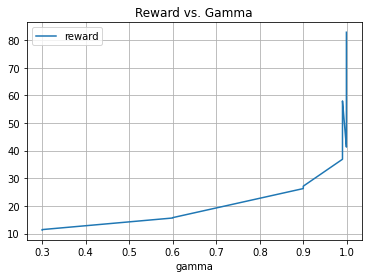

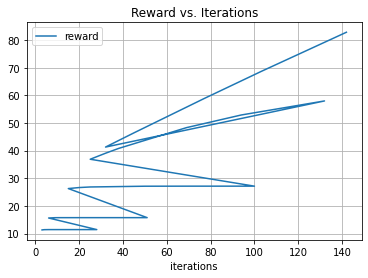

In [58]:
vi_data_FM20.plot(x='gamma', y='reward', title="Reward vs. Gamma")
plt.grid()

vi_data_FM20.plot(x='iterations', y='reward', title="Reward vs. Iterations")
plt.grid(True)

Best Result:
	Reward = 82.85
	Gamma = 0.9990000
	Epsilon= 1E-18


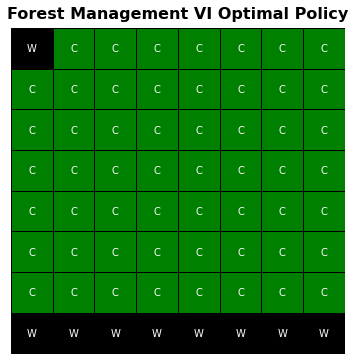

In [59]:
# find the highest score
bestRun = vi_data_FM20['reward'].argmax()
bestPolicy = vi_data_FM20['policy'][bestRun]

title='Forest Management VI Optimal Policy'
plot_forest(bestPolicy, title, f_size=8)

# Save off data to a csv file
# vi_data.to_csv('forest/VI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\tEpsilon= %.E' % (vi_data_FM20['reward'].max(), vi_data_FM20['gamma'][bestRun], vi_data_FM20['epsilon'][bestRun]))

<h3>Policy Iteration</h3>

In [60]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="iterative") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            plot_forest(policy, title)
            pass
        
        testnum = testnum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [61]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99,  0.999]
pi_data_FM20  = policyIteration(FM20_T, FM20_R, gammas, showResults=False)

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.00,	1,	9.679744
0.20,	0.00,	2,	10.475809
0.30,	0.00,	2,	11.420631
0.40,	0.00,	2,	12.560725
0.50,	0.00,	3,	13.965756
0.60,	0.00,	3,	15.746658
0.70,	0.00,	4,	18.098344
0.80,	0.00,	5,	21.433477
0.90,	0.00,	6,	27.144654
0.99,	0.07,	8,	68.915785
1.00,	0.49,	8,	440.065406
Time taken: 0.59


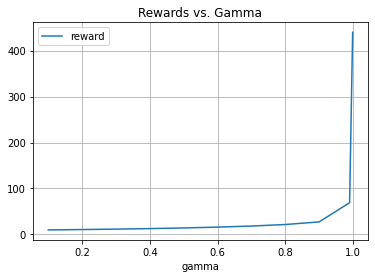

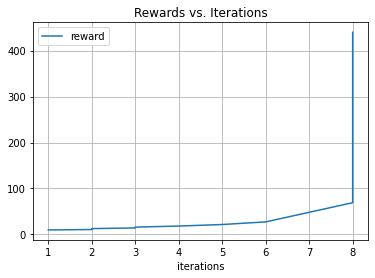

In [62]:
pi_data_FM20.plot(x='gamma', y='reward', title='Rewards vs. Gamma')
plt.grid()

pi_data_FM20.plot(x='iterations', y='reward', title='Rewards vs. Iterations')
plt.grid()

Best Result:
	Reward = 440.07
	Gamma = 0.999


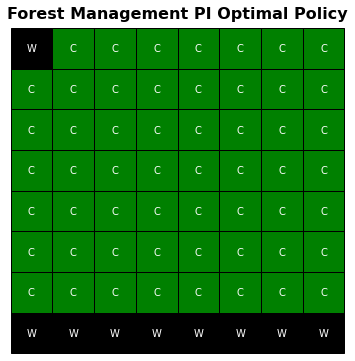

In [63]:
# find the highest score
bestRun = pi_data_FM20['reward'].argmax()
bestPolicy = pi_data_FM20['policy'][bestRun]

title='Forest Management PI Optimal Policy'
plot_forest(bestPolicy, title, f_size=8)

# Save off data to a csv file
# pi_data_FM20.to_csv('forest/PI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.3f' % (pi_data_FM20['reward'].max(), pi_data_FM20['gamma'][bestRun]))

<h3> Q- Learning Convergence code 64 states </h3>

In [25]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl8_q =  QLearning(FM20_T, FM20_R, gamma=.999, alpha=0.1, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
# QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl8_q.run()
p_policy = fl8_q.policy

fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl8_q_curated_results["Mean V"])
V_Max_8 =[]
V_Max_8.append(p_max_v)
p_nvar= 0
l_check = 0
for i in range(500):
    fl8_q.run()
    n_policy = fl8_q.policy
    fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl8_q_curated_results["Mean V"])
    c_m_V = max(fl8_q_curated_results["Max V"])
    V_Max_8.append(n_max_v)
    fl8_q.alpha = 0.07 # your prefered alpha
    fl8_q.epsilon = 1
    
    if i > 20:
        n_var= np.var(V_Max_8[:-10])
        diff = abs(n_var-p_nvar)
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 470):
            print('converged')
            break
            
            

353.90767115590273
343.5777179561937
76.54193496242266
350.6519173747724
87.36081626618795
357.5621733691027
95.06156779044818
363.93350044351155
104.67870133115036
370.1100503964179
114.1111467362606
375.9123400665563
125.00175930254943
381.3743951509128
133.25474595196374
386.4278044701722
140.21003516846713
391.31764490089756
147.95212351658301
395.9285419572005
156.07044753499054
400.22664528593003
161.91021644711327
404.3629928948257
170.23037818324292
408.28174909384995
176.45651195287746
411.90926872211463
181.82582441884324
415.3122172881322
190.3120842855842
418.4886124339862
196.93712863186556
421.4682446881152
202.50632021013234
424.3663852690472
209.5771142184035
427.13478673146136
217.99144648984202
429.5892391150996
224.21425287820102
432.0756646105524
226.1371976027308
434.3531523245496
230.42279742799747
436.4854490958999
233.66485568606595
438.66738352028045
234.42558329207986
440.63950561344984
239.79917956633017
442.4504630885012
244.44742913712525
444.2398641826253


31.355038932015304
474.9003642521292
31.434574871069344
474.90023715507823
31.505337135236914
474.8997200984584
31.571062548788177
474.89637963479703
31.628304413992737
474.8969551451174
31.684871115969145
474.8969551451174
31.737584962036635
474.8951707348917
31.79050172154166
474.8936389937887
31.833600571830175
474.893378166037
31.878096161621215
474.8905199369585
31.91667753639922
474.89129467772995
31.954520811606926
474.8920201723037
31.987918757182342
474.8934392522425
32.01284721838965
474.9050538487396
32.03823941747396
474.9061281574559
32.06708021603845
474.9073044923839
32.08682071183648
474.91529740349466
32.101958616600314
474.9172589328283
32.117524926212354
474.91816600739054
32.12493858567541
474.91983447326396
32.12671973796387
474.9227454014541
32.12823895260226
474.9232165073029
32.1289402743605
474.92331895788635
32.12752368412839
474.9276736764179
32.12228924082592
474.9276736764179
32.113407405231555
474.92718502456603
32.10341515384425
474.9268748959883
32.08873

19.492215216154364
502.5286172020507
19.43283033757325
502.8887785300125
19.374645585749022
503.0282521969089
19.315442206709122
502.91282267905325
19.25695721158445
503.09898694463567
19.199609983148548
503.12781590139855
19.141600114337052
503.3336392138725
19.083688323449678
503.3251623021773
19.026934452669593
504.15773698374187
18.971001687938042
504.30458346579366
18.91225011185452
505.4944859342749
18.85367307713568
505.6027252793785
18.796330552760992
505.64873633304296
18.740289222774663
505.72011509809226
18.683130052026172
505.76786861708274
18.627333108190214
505.81358817715875
18.571926757702386
505.8888947503951
18.5183752502071
506.00836804557855
18.457233003873625
506.3186822084008
18.401619932999893
506.70787384642995
18.338677205634667
506.6463663679925
18.283601342644033
506.51523431881685
18.229897089944643
506.5749722839583
18.176591312334494
506.58011399781805
18.122771040267253
506.502946470359
18.069220854022205
506.61848401404296
18.01569033393571
506.591776597

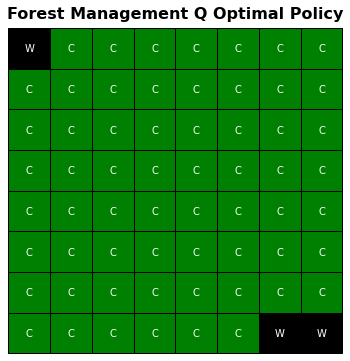

In [26]:
title='Forest Management Q Optimal Policy'
plot_forest( np.array(list(fl8_q.policy)), title, f_size=8)

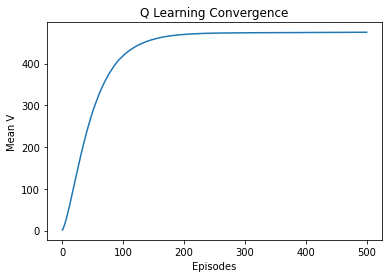

In [27]:
plt.plot(range(0,len(V_Max_8), 1),V_Max_8 )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

<h3> Q- Learning Convergence code 64 states Changed Rewards</h3>

In [65]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl8_q =  QLearning(FM20_T, FM20_R, gamma=.999, alpha=0.1, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
# QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl8_q.run()
p_policy = fl8_q.policy

fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl8_q_curated_results["Mean V"])
V_Max_8 =[]
V_Max_8.append(p_max_v)
p_nvar= 0
l_check = 0
for i in range(500):
    fl8_q.run()
    n_policy = fl8_q.policy
    fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl8_q_curated_results["Mean V"])
    c_m_V = max(fl8_q_curated_results["Max V"])
    V_Max_8.append(n_max_v)
    fl8_q.alpha = 0.07 # your prefered alpha
    fl8_q.epsilon = 1
    
    if i > 20:
        n_var= np.var(V_Max_8[:-10])
        diff = abs(n_var-p_nvar)
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 470):
            print('converged')
            break
            
            

219.3434717559614
301.3885778472759
49.60469541594682
307.42647692308367
54.977760309044356
313.26258747590754
61.57983219193244
318.7741271323461
68.63086117994743
323.8839263742241
71.93065322997569
328.91519090742094
77.11279585821126
333.58891248898396
82.20542621324626
337.9325657709994
89.565414065396
342.07558538688
93.15703037813262
345.91846723250256
100.41685923876923
349.6263137233373
103.6010696664714
353.1381542240623
107.66562259002899
356.4201992618761
113.40236610616353
359.48795212673986
120.91264330150216
362.5066205520229
127.66971091708615
365.3144022830017
129.97648920573715
367.85884316387563
134.33408580279
370.3412826207323
138.84784118058155
372.666995041252
144.83052169213624
375.0478000399547
150.25517990018898
377.0818137196377
152.97360682901717
379.1636230314484
156.095576869031
381.16403238708983
159.89583177497934
382.72248870571207
163.06295717326202
384.4645141692797
166.1571626822638
385.96340211968993
168.42681466482782
387.6751340953301
171.48750162

21.206218255329077
414.34675035910203
21.30383152687864
414.35634855373485
21.397220318523978
414.3687635211751
21.49664908323757
414.3766229025323
21.587500532834383
414.38591676809733
21.671042255366046
414.39964006033387
21.738824572688827
414.425969984079
21.804659057830577
414.43468842344316
21.879511487772106
414.441870344233
21.939505649937928
414.45004335708103
21.997572701220633
414.4790178693978
22.053821560481083
414.48969673675117
22.110641956993277
414.5228651922209
22.163954474517595
414.54500004542837
22.209800030699625
414.558922201932
22.25959166615212
414.5738240892929
22.309871595731238
414.58590966050707
22.350417034856946
414.6162987923357
22.392448501490435
414.62885469211744
22.430620936384003
414.6373147933985
22.458594042973345
414.6441087963324
22.488042726941785
414.6670682100647
22.51354366958367
414.679468856613
22.54059897339539
414.68992223960987
22.56170894945717
414.7022474563898
22.57594885231447
414.7101717192809
22.593024530418916
414.77370244102565


15.169447405671235
440.47658897814574
15.12596976862551
441.082370831256
15.084012393717785
440.9792910118503
15.04353333866311
440.87736470853645
14.999587636646538
440.8024247115401
14.953510327524782
439.9893007886345
14.910295967529237
439.9331128673557
14.869388999535659
440.00040504284055
14.82875547560252
440.00040504284055
14.788561065923204
439.93341535643344
14.739946316811256
440.9451898267688
14.694003376069304
440.74262005960196
14.654364242071097
440.81952263677783
14.615929362689712
440.75557653509
14.574700543247673
440.7074665318157
14.538709736918463
440.458869626203
14.500309367171212
440.61383841122256
14.461743805744845
440.5098401742478
14.421438865818345
440.4574039713529
14.38458837316648
440.5544706184826
14.34263311379982
440.7783426528997
14.303324858838096
441.0210837942895
14.265740514461868
441.16808814167223
14.224788533065293
441.17689956911596
14.186016829036816
441.2564532367025
14.144535884062861
441.15809768539697
14.103968195367997
440.0424331808340

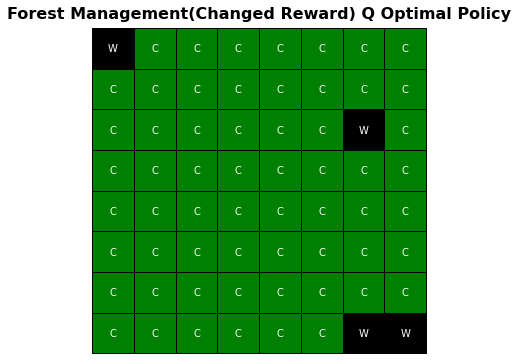

In [67]:
title='Forest Management(Changed Reward) Q Optimal Policy'
plot_forest( np.array(list(fl8_q.policy)), title, f_size=8)

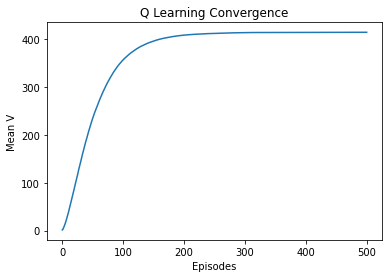

In [66]:
plt.plot(range(0,len(V_Max_8), 1),V_Max_8 )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

<h3>Problem 3 both combined q learning effects</h3>

In [70]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        #policy = np.array(test.policy)
                        #policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            pass
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    '''
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
    '''
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [122]:
gammas         = [ 0.999]
alphas         = [ 0.1, 0.2]
alpha_decays   = [0.9, 0.999]
epsilon_decays = [0.9, 0.99, 0.9999]
iterations     = [1e6]

# FM8_T, FM8_R = forest(S=64)
# FM18_T, FM18_R = forest(S=324)

# ql_data_FM8  = qLearning(FM8_T, FM8_T, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)
# ql_data_FM18  = qLearning(FM18_T, FM18_T, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)

ql_data_FM5  = qLearning(FM5_T, FM5_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)
ql_data_FM25  = qLearning(FM25_T, FM25_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)


Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
1.00,	0.10,	38.03,	1000000,	173.878675
Test Num 2/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.990,	Iterations:1000000
1.00,	0.10,	35.17,	1000000,	174.750660
Test Num 3/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:1.000,	Iterations:1000000
1.00,	0.10,	33.85,	1000000,	173.843395
Test Num 4/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:1000000
1.00,	0.10,	34.06,	1000000,	186.193587
Test Num 5/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.990,	Iterations:1000000
1.00,	0.10,	35.87,	1000000,	185.995912
Test Num 6/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:1.000,	Iterations:1000000
1.00,	0.10,	35.06,	1000000,	178.969106
Test Num 7/12
Gamma: 1.00,	Alpha: 0.20,	Alpha Decay:0.900,

In [123]:
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations' ,'policy', 'time', 'reward']
df1 = ql_data_FM5[interest]
df1.columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations','policy_25', 'time_25', 'reward_25']

interest2 = ['time',  'reward' ,'policy']
df2 = ql_data_FM25[interest2]
df2.columns = ['time_625', 'reward_625','policy_625']



In [124]:
result = pd.concat([df1, df2], axis=1)
result

# cm = seaborn.light_palette('green', as_cmap='True')
# s = result.style.background_gradient(cmap=cm)
# s

,gamma,alpha,alpha_decay,epsilon_decay,iterations,policy_25,time_25,reward_25,time_625,reward_625,policy_625
0,0.999,0.1,0.900,0.9000,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,...",38.030010,173.878675,64.624126,173.363203,"{(0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,..."
1,0.999,0.1,0.900,0.9900,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,...",35.165604,174.750660,66.021145,173.287976,"{(0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,..."
2,0.999,0.1,0.900,0.9999,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",33.847289,173.843395,68.060503,172.958146,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,..."
3,0.999,0.1,0.999,0.9000,1000000.0,"{(0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,...",34.055874,186.193587,67.908246,185.441994,"{(0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,..."
4,0.999,0.1,0.999,0.9900,1000000.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,...",35.867045,185.995912,68.113247,184.585588,"{(0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,..."
5,0.999,0.1,0.999,0.9999,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...",35.064401,178.969106,69.733311,178.168089,"{(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,..."
6,0.999,0.2,0.900,0.9000,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,...",35.695339,173.985576,69.304157,173.640656,"{(0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,..."
7,0.999,0.2,0.900,0.9900,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",34.464298,174.562191,68.501051,173.447613,"{(0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,..."
8,0.999,0.2,0.900,0.9999,1000000.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",34.358717,173.621689,68.706372,173.002073,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,..."
9,0.999,0.2,0.999,0.9000,1000000.0,"{(0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,...",34.687182,199.017307,67.882154,50.986269,"{(0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,..."


<h3> Q- Learning Convergence code 625 states </h3>

In [85]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl25_q =  QLearning(FM25_T, FM25_R, gamma=.999, alpha=0.1, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
# QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl25_q.run()
p_policy = fl25_q.policy

fl25_q_curated_results = make_time_array(fl25_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl25_q_curated_results["Mean V"])
c_m_V = max(fl25_q_curated_results["Max V"])
V_Max_25 =[]
V_Max_25_M =[]
V_Max_25.append(p_max_v)
V_Max_25_M.append(c_m_V)
p_nvar= 0
l_check = 0
for i in range(1200):
    fl25_q.run()
    n_policy = fl25_q.policy
    fl25_q_curated_results = make_time_array(fl25_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl25_q_curated_results["Mean V"])
    c_m_V = max(fl25_q_curated_results["Max V"])
    V_Max_25.append(n_max_v)
    V_Max_25_M.append(c_m_V)
    fl25_q.alpha = 0.07 # your prefered alpha
    fl25_q.epsilon = 1
    
    if i > 100:
        n_var= np.var(V_Max_25[:-10])
        diff = abs(n_var-p_nvar)
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 570):
            print('converged')
            break
            
            

8990.807131610336
469.81750551200753
0.0
470.0082161719579
0.0
470.15305064493646
0.0
470.3264708440115
0.0
470.4837165048695
0.0
470.65659284839734
0.0
470.7807261908959
0.0
470.92147165569594
0.0
471.07097295751197
0.0
471.20629036131027
0.0
471.3287439242868
0.0
471.4478500478614
0.0
471.5346682789814
0.0
471.63973838440717
0.0
471.7138599594338
0.0
471.8232723360082
0.0
471.9201719795266
0.0
471.9850992028758
0.0
472.0532652757665
0.0
472.11238421750164
0.0
472.187675505919
0.0
472.2529616583382
0.0
472.32180672187013
0.0
472.3884085109997
0.0
472.4674920526677
0.0
472.5161511651557
0.0
472.6003239141222
0.0
472.65929538550205
0.0
472.7206611078623
0.0
472.8093828306218
0.0
472.8605445712204
0.0
472.8953051943627
0.0
472.9463547337489
0.0
473.01099626857194
0.0
473.0858886865152
0.0
473.1604677013067
0.0
473.1732571081093
0.0
473.20935615688006
0.0
473.23695434642366
0.0
473.2739989768436
0.0
473.2993327175041
0.0
473.33551805804103
0.0
473.336048300401
0.0
473.3583874113139
0.0
47

0.0
474.0333995515573
0.0
474.02195463961164
0.0
474.0194676325696
0.0
474.01753476137856
0.0
474.0150253147761
0.0
474.0241083328428
0.0
474.04255597769804
0.0
474.049001598784
0.0
474.03613503978545
0.0
474.05006158461237
0.0
474.06135188875515
0.0
474.0598548186088
0.0
474.03342363763954
0.0
474.02087780309824
0.0
474.0188596476276
0.0
474.0161924870574
0.0
474.01269933228804
0.0
474.00831324381164
0.0
474.0039119280265
0.0
473.9999816671269
0.0
473.9968115858015
0.0
473.9919709429546
0.0
473.98883303732197
0.0
473.98491791753645
0.0
473.98150600463407
0.0
473.9782454774212
0.0
473.9752106819535
0.0
473.9710541943476
0.0
473.9668628632935
0.0
473.9629169153641
0.0
473.9591312220454
0.0
473.95975958693305
0.0
473.96623464235364
0.0
473.95913916538564
0.0
473.96863074771295
0.0
473.97009842453434
0.0
473.98030179266954
0.0
473.9884651519461
0.0
473.99165943798437
0.0
473.9841434968667
0.0
473.97692806494325
0.0
473.97328402800946
0.0
473.9768925132564
0.0
474.0085666270004
0.0
474.013

0.0
474.1292536542252
0.0
474.1470905727394
0.0
474.1580320277889
0.0
474.15840965679814
0.0
474.1452422483696
0.0
474.1216739241188
0.0
474.1106993170836
0.0
474.1176670626693
0.0
474.10815307259645
0.0
474.1025125350412
0.0
474.10129861376237
0.0
474.0903812819038
0.0
474.1075889036635
0.0
474.1234240605537
0.0
474.12846271102285
0.0
474.12649459720006
0.0
474.10853121551105
0.0
474.0964120638294
0.0
474.08950914212255
0.0
474.08839322330925
0.0
474.08685772528423
0.0
474.0827209197815
0.0
474.0791747003643
0.0
474.07539950623845
0.0
474.0711630487602
0.0
474.0652593926481
0.0
474.0607322947065
0.0
474.05708779162126
0.0
474.0529539760042
0.0
474.0498514004183
0.0
474.04647868923723
0.0
474.0411737032498
0.0
474.0352021543613
0.0
474.0320902843472
0.0
474.0443441880511
0.0
474.04423287626514
0.0
474.0398168810609
0.0
474.0396662153752
0.0
474.0312571230181
0.0
474.02892539174866
0.0
474.0266364929401
0.0
474.0247067615772
0.0
474.0234031342995
0.0
474.0212105099595
0.0
474.0193074158

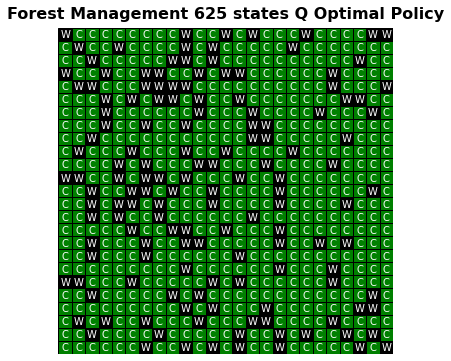

In [90]:
title='Forest Management 625 states Q Optimal Policy'
plot_forest( np.array(list(fl25_q.policy)), title, f_size=25)

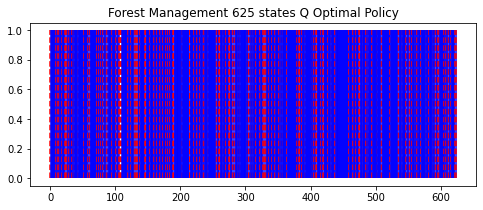

In [105]:
plot_fm_policy(fl25_q.policy, title='Forest Management 625 states Q Optimal Policy' )

Above one is suboptimal

In [112]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl25_q2 =  QLearning(FM25_T, FM25_R, gamma=.999, alpha=0.1, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
# QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl25_q2.run()
p_policy = fl25_q2.policy

fl25_q2_curated_results = make_time_array(fl25_q2.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl25_q2_curated_results["Mean V"])
c_m_V = max(fl25_q2_curated_results["Max V"])
V_Max_252 =[]
V_Max_252_M =[]
V_Max_252.append(p_max_v)
V_Max_252_M.append(c_m_V)
p_nvar= 0
l_check = 0
for i in range(2400):
    fl25_q2.run()
    n_policy = fl25_q.policy
    fl25_q2_curated_results = make_time_array(fl25_q2.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl25_q2_curated_results["Mean V"])
    c_m_V = max(fl25_q2_curated_results["Max V"])
    V_Max_252.append(n_max_v)
    V_Max_252_M.append(c_m_V)
    fl25_q2.alpha = 0.07 # your prefered alpha
    fl25_q2.epsilon = 1
    
    if i > 100:
        n_var= np.var(V_Max_252[:-10])
        diff = abs(n_var-p_nvar)
        print(diff)
        print(c_m_V)
        print(i)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 570):
            print('converged')
            break
            
            

751.126312551403
472.65045061335724
16.55303097482897
472.697924028962
16.680955570657602
472.7221688749581
16.820747539410945
472.8326406973143
16.982053841692277
472.9547238259495
17.0947003906158
473.1091615751712
17.224317418136934
473.1862087670064
17.36131814533337
473.2752616207743
17.475796772232457
473.3051332543863
17.61515505698287
473.3192638811077
17.73654204973377
473.3488231533548
17.82900795098726
473.35973916458704
17.94824732631264
473.4582003559947
18.086829135725907
473.52059135261123
18.221083488498948
473.5535683077852
18.353581588317297
473.5529990209834
18.50225295404448
473.54431495110475
18.687037418091222
473.54250861787085
18.81730041724154
473.56814699363616
18.86254598500159
473.57806350544894
18.930861460364213
473.56725660412326
19.034776359378156
473.62025989067786
19.197145037252085
473.6580484396246
19.247405022000976
473.7306558760934
19.352704106832334
473.7749939261719
19.505398975826665
473.7891417766366
19.64693449681681
473.7991718737988
19.7632

24.958049355411276
474.28614838084934
24.933973478175176
474.284366204115
24.915469641799973
474.28158715958585
24.881003317392242
474.2650730437044
24.861865955767826
474.2639547651337
24.835338181507723
474.26113781997327
24.822067187277753
474.2605902250456
24.8060569224981
474.26049196877665
24.791080933765443
474.25686184518935
24.781501828990258
474.2553247289617
24.760544452841714
474.253649477065
24.771205753596405
474.25354378427124
24.744638467853292
474.25214130540604
24.72779829888077
474.2499321941307
24.69483354703516
474.2496089327016
24.674104068286397
474.2469788233558
24.659167866558164
474.21561839540004
24.63782756056844
474.20999860363213
24.618212123158628
474.2096850150875
24.592345578165805
474.20114158282115
24.5718328605808
474.19660438141256
24.55793265199918
474.2458743081147
24.52293338797881
474.2490544521863
24.48851598163219
474.2277630072637
24.45106627280984
474.2085043339283
24.40628634211771
474.2198969392688
24.366634791856995
474.27798371562557
24.

17.663580047801588
474.25484198902336
17.633583214501414
474.251870620538
17.587144963175888
474.23674719823293
17.55526649456624
474.2177819630698
17.519393306698475
474.21743270868456
17.479179477475554
474.21743270868456
17.438574183974197
474.2093956476606
17.400055205016542
474.1984778260424
17.362827837227087
474.1961094299848
17.319171317332803
474.2124691453923
17.2798156384506
474.2620767699872
17.247557627024435
474.2233945399863
17.20905959986885
474.2739891715809
17.157923817088886
474.2806342741827
17.115130402879004
474.2453047011797
17.0664811091101
474.2655351183979
17.024875069264453
474.2671481430723
16.982654183975683
474.2817390923796
16.947221157037347
474.3278766026341
16.90928787095072
474.2921311773832
16.867570353844712
474.27939645749154
16.82850636019066
474.254622078681
16.78366900731453
474.2147046933122
16.747512141560946
474.21458811143276
16.71387593227155
474.2327787611721
16.678586653968523
474.2112010266813
16.63951475664726
474.2037805530746
16.59992

9.694471004037041
474.5528123042351
9.663453699042293
474.6282844888623
9.639758360466658
474.60747370518146
9.60859664025702
474.5902554924434
9.574869528893032
474.593056714636
9.54369228979158
474.58101534334673
9.514101441518505
474.5612982702125
9.483619938398988
474.5360713031525
9.454580514959162
474.5121326071425
9.429576722030106
474.493231756004
9.403112275236708
474.47329515292716
9.371981402815436
474.496237236956
9.342378312601795
474.4732150588792
9.312829233580487
474.4714841144608
9.28096745784569
474.4630215332797
9.252462595701218
474.45352081675725
9.2220801017138
474.44824912759003
9.188036132940397
474.4418542876042
9.15958846616013
474.43812946503886
9.1311345511549
474.42921796008955
9.100869926043742
474.41777216614423
9.071608356671277
474.4106479590295
9.042025253816973
474.39093715557647
9.017748117617884
474.38096769515823
8.990513857908809
474.3603746777997
8.961124463256056
474.35908419330275
8.9305367884117
474.3587048915353
8.901958405802361
474.35870489

3.985418708956786
474.37639997342905
3.965493677342238
474.3531205490889
3.946457635702245
474.3742165595737
3.926296083827765
474.3969152551561
3.9067418987342535
474.44601953996437
3.8878155349757435
474.5097184742772
3.8673622019432514
474.49340106920243
3.8473621767934674
474.47579138224717
3.8284151854986703
474.5072639810762
3.8110090210866474
474.5170092853112
3.7905980360592366
474.5026790797982
3.7712669868797093
474.4671473087039
3.752824487623002
474.45814325650116
3.7343778489848773
474.4330186680415
3.713503644166849
474.4197106012066
3.6924851708481583
474.4003904742444
3.6722944260545773
474.38913974196606
3.652856158621944
474.37118901582403
3.635076668837428
474.3593145377571
3.6160460171322484
474.3554780911898
3.597164451972276
474.35461898824065
3.57767931694616
474.3475303359326
3.5605723738317465
474.3419213162639
3.542349346776973
474.3389991105314
3.5221458314263145
474.3389991105314
3.5022991103705863
474.33202241994684
3.4826673982588545
474.3314719029823
3.46

0.5503080859180045
474.1988594732749
0.538894919485756
474.1987881771967
0.527168801318112
474.22367745407973
0.5155212742683943
474.2661044205779
0.5026686592518672
474.25332305907233
0.4903298230983637
474.2225080385882
0.478149050653883
474.22213592519364
0.46674122459444334
474.2013912005066
0.45474130707225413
474.2012902947395
0.4434199464849371
474.2012149219217
0.4327019084848871
474.2294456932039
0.42147725617724063
474.2441832587892
0.4114393677627959
474.2602282542572
0.4001598133945663
474.2780922664177
0.3886540633538971
474.29599621974523
0.3780582752024202
474.3158439879442
0.3666774902449106
474.2946747277023
0.35601531382963003
474.2893146526169
0.3447513199516834
474.2777787625411
0.33421196165181755
474.24828703810516
0.322734791201583
474.2727867414764
0.3118205368082272
474.2781290190567
0.30090123315312667
474.31003218129734
0.2904903752132668
474.3000831644684
0.27965554183720087
474.25919589767534
0.2681838964581402
474.24669799582256
0.2567049362605758
474.2226

1.3717560461591347
474.2909660740953
1.3777944357207161
474.2761073000314
1.3842885468457098
474.26936749490466
1.3904222952569398
474.2686454859366
1.3966212352861476
474.26144442339626
1.4028668565006228
474.2525691317253
1.4093523785559228
474.2377977294988
1.4153309451849054
474.22929755733986
1.4214997663239046
474.2222886664721
1.4276376568686828
474.21929384498776
1.4338181391940452
474.20189262464004
1.4399741235665715
474.200052136439
1.4462205034360522
474.1997394197049
1.4522529073001351
474.19345302796654
1.458678602519285
474.19218716323326
1.4647310257478239
474.1919795583585
1.470976377833722
474.1907427305396
1.4768795162908646
474.15950758691713
1.4832637607032666
474.1591521405753
1.4893115353370376
474.15359698542227
1.4956881765701837
474.1532427681962
1.5019788763784163
474.1521745062128
1.5083892588281742
474.15156158560194
1.514820074533418
474.14170732327597
1.5208750683632388
474.14170732327597
1.5270792442734091
474.1414799637915
1.532954148706267
474.14106318

2.3897910702598892
474.53238504559
2.392768580088159
474.56247243512996
2.395804223109735
474.5412926035051
2.398575571933179
474.5144565014776
2.4014522834986565
474.5018091653784
2.4043557240111113
474.4976137805447
2.4072804956194886
474.49060540697934
2.4101950457825296
474.504795154465
2.412971623161866
474.55661847924074
2.4159545011862065
474.5366192266945
2.418888534710277
474.55182308683237
2.4216369703844975
474.5204714633475
2.4244944063339062
474.52770613238096
2.427394093701878
474.552193672223
2.430414306514649
474.52428662883904
2.4332842311378045
474.51192603370293
2.436202603355923
474.4991540576547
2.438996899709309
474.4776764626232
2.4417847939766943
474.4916634732762
2.4446334859676426
474.4890398108833
2.4469679153044126
474.5156911543054
2.449674263543784
474.47917198874046
2.452278997292524
474.4677113928885
2.4549915258085093
474.4684726287375
2.457794496909628
474.4673032265136
2.4604049924673745
474.4558027168238
2.4632384000451566
474.4497259850313
2.4658778

2.848720962720108
474.70787754844025
2.849976244931895
474.70859557110884
2.851363925910846
474.7143537770406
2.8525782849010284
474.71511058151714
2.853932680984144
474.716450886669
2.8551438864615193
474.716450886669
2.8564514373883867
474.7167504461938
2.857576397002049
474.7181508331654
2.8588134382789576
474.71834683876494
2.8600408492548013
474.71878189950365
2.8611336059639143
474.7190421775224
2.8622660912005813
474.7194541549002
2.8634261971819797
474.71967351257007
2.8645595007492375
474.71967351257007
2.8658076952779084
474.7198875706597
2.8670437391119776
474.7200635044109
2.8682414372469793
474.72045068649413
2.8695955876082735
474.72045068649413
2.8708475270723284
474.7206636125267
2.8720364493037778
474.72090016855
2.8731656021536764
474.72090016855
2.874351262438722
474.72090016855
2.875509426539793
474.7211576271997
2.876670776406172
474.7216592443043
2.877735847234362
474.732301176718
2.8789276198604057
474.73256739419037
2.8800483757513575
474.73318835251996
2.881153

2.993495947039264
474.952896534424
2.993688888829638
474.952896534424
2.993883215862297
474.95350166190934
2.9940684095745382
474.95350166190934
2.9942634958679264
474.95370731418444
2.9943748985479033
474.95370731418444
2.994563893553277
474.9539538490442
2.9947769316713675
474.95413784476943
2.994894899409701
474.95413784476943
2.9950450052874658
474.9547753092596
2.995238316409086
474.9547753092596
2.9953928330087365
474.95505528693326
2.9955182551693724
474.95505528693326
2.9956504695783224
474.95505528693326
2.9957675941932393
474.95505528693326
2.9959371041240956
474.9554996261777
2.9960395746693393
474.9559409788304
2.996207755169962
474.95636026813145
2.9963534268172225
474.95689143628147
2.9964714413454203
474.95740090257453
2.9965472366948234
474.9577415937517
2.996623780565642
474.9577415937517
2.99676948609158
474.95804919100885
2.996836709784475
474.9586570951046
2.9969102212908183
474.9712210623151
2.9970363829161215
474.9714448583047
2.9971064742203453
474.97212253944133

2.960767445019883
475.1057962611864
2.9604394408725057
475.10605667297466
2.96007317459771
475.1064398686893
2.9597001542879298
475.1066021952937
2.9593021714790666
475.1068606057257
2.958964285249749
475.1068606057257
2.95864258207439
475.1077979513724
2.95822701482939
475.10813667074297
2.9577759053026966
475.10813667074297
2.957401683293938
475.1086896980369
2.9569981225395168
475.10892960476525
2.956594997387583
475.1091909124953
2.956172255675483
475.10971696311077
2.955741938269057
475.1100672957551
2.955278472363716
475.1102884196315
2.954840931321087
475.1111694177192
2.9544329134168947
475.1111694177192
2.954041321767363
475.1116672047024
2.953640898471349
475.1118189887445
2.9532152175106603
475.1119756233639
2.952829932795794
475.11286568468205
2.9524262016111606
475.1132461885038
2.9520332258016424
475.1134705118972
2.951589237070948
475.1138717687889
2.9511406107594667
475.1138717687889
2.950717566684034
475.11447333109703
2.9502704630212975
475.11447333109703
2.9498563299

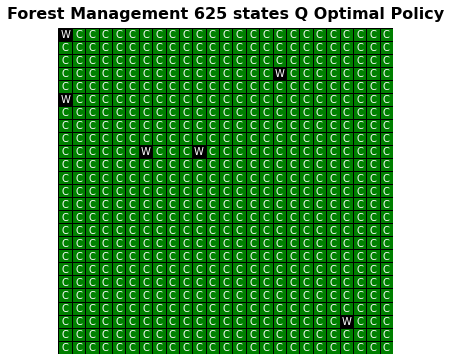

In [113]:
title='Forest Management 625 states Q Optimal Policy'
plot_forest( np.array(list(fl25_q2.policy)), title, f_size=25)

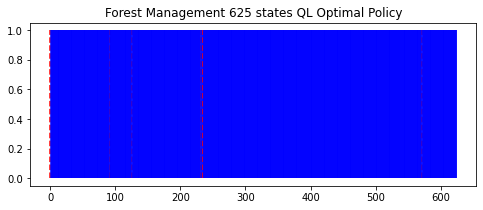

In [125]:
plot_fm_policy(fl25_q2.policy, title='Forest Management 625 states QL Optimal Policy' )

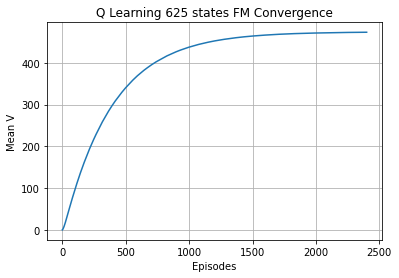

In [115]:
plt.plot(range(0,len(V_Max_252), 1),V_Max_252 )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning 625 states FM Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph

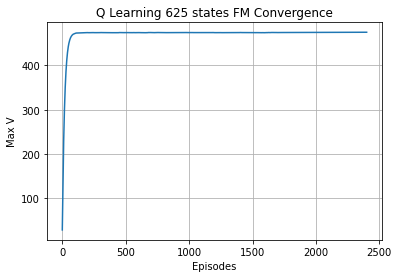

In [116]:
plt.plot(range(0,len(V_Max_252_M), 1),V_Max_252_M )
plt.xticks()

plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning 625 states FM Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph